In [4]:
%load_ext autoreload
%autoreload 2

import os 
import pandas as pd
import nibabel as nib
from bpreg.scripts.bpreg_inference import bpreg_inference
from bpreg.inference.inference_model import InferenceModel
from docs.notebooks.utils import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data
Load data from Zenodo: 
https://zenodo.org/record/5211537#.YRuny9axWEA

For this analysis the [APOLLO-5-LSCC](https://wiki.cancerimagingarchive.net/display/Public/APOLLO-5-LSCC#95224279e16fe234091144e28bf0dcf8d5f2eb4c) data from the Cancer Image Archive was used. <br>
In Zenodo you will find the the CT images from the study converted into the npy-format. 

## 1.1 Define variables

In [5]:
meta_data_path = "data/APOLLO/meta-data.xlsx"
npy_path = "data/APOLLO/npy-files/"
json_path = "data/APOLLO/json-files/"

if not os.path.exists(json_path): os.mkdir(json_path)
df = pd.read_excel(meta_data_path, index_col=0)
model = InferenceModel()

## 2. Create body part meta-data file for npy files 
If CT images in the npy-format are used for inference, it has to be taken care of a few points: 
- the intensity scale in the CT images needs to be in Hounsfield Units (HU) 
- the pixel-spacings in x y and z-direction needs to be given as tuple: 
(pixel spacing x, pixel spacing y, pixel spacing z)
- The axis order needs to be defined. For example, if we have a CT volume with the shape of 512 x 512 x 120 pixels and the axis ordering xyz, we need to pass the tuple (0, 1, 2) into the function. 

In [6]:
for file in tqdm(os.listdir(npy_path)): 
    X = np.load(npy_path + file)
    pixel_spacings = df.loc[file]
    bodypart_metadata = model.npy2json(X, 
                                       json_path + file.replace(".npy", ".json"), 
                                       pixel_spacings, 
                                       axis_ordering=(0, 1, 2))


100%|██████████| 38/38 [00:28<00:00,  1.36it/s]


## 3. Analyze input in metadata files
In the the path json_path for each file a meta-data file was created. <br>
Let's have a look into the meta-data files. 

### 3.1 Analyze body part distirbution in dataset

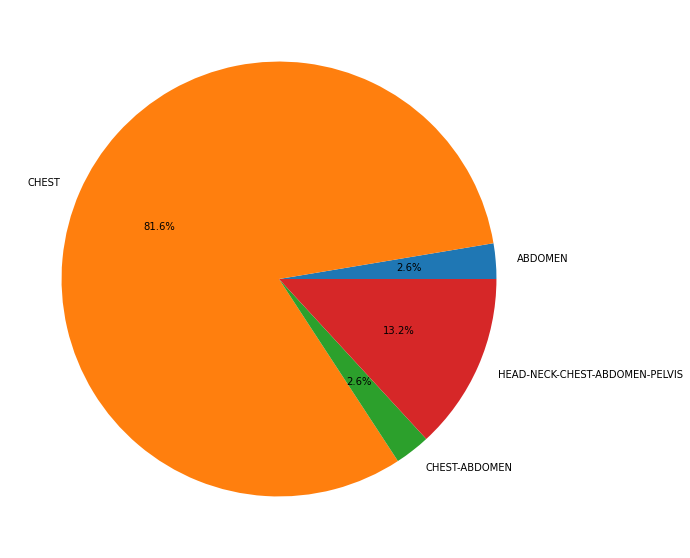

In [7]:
bodyparts = []

for file in os.listdir(json_path): 
    with open(json_path + file, "rb") as f: 
        bodypart_metadata = json.load(f)
    bodyparts.append(bodypart_metadata["body part examined tag"])
    
unique_bodyparts = np.unique(bodyparts)
counts = [bodyparts.count(word)/len(bodyparts) for word in unique_bodyparts]

_, ax = plt.subplots(figsize=(10, 10))
_, texts, autotexts = ax.pie(counts, 
                             labels=unique_bodyparts,
                             autopct='%1.1f%%')
plt.show()

### 3.2 Analyze individual JSON meta-data files

In [ ]:
i = 12
file = os.listdir(json_path)[i]
X = np.load(npy_path + file.replace(".json", ".npy"))

# Print meta-data
print(f"Analyze file: {file}\n-----------------------------------")
with open(json_path + file, "rb") as f: 
    bodypart_metadata = json.load(f)

# Predict Body Part Examined
print("Predicted Body Part Examined: ", bodypart_metadata["body part examined tag"])

# Plot Slice Scores
plt.plot(bodypart_metadata["z"], bodypart_metadata["cleaned slice scores"])
plt.title("Slice score curve", fontsize=20)
plt.xlabel("Height [mm]", fontsize=18)
plt.ylabel("Slice Scores", fontsize=18)
plt.show()

# Print look-up table 
print("Slice score look up table: ")
lookup = pd.DataFrame(bodypart_metadata["look-up table"]).T
display(lookup)

# Plot coronal slice of CT volume
print(f"Shape of CT volume: {X.shape}")
print(f"Minimum HU value in CT volume: {np.min(X)}")
print(f"Maximum HU value in CT volume: {np.max(X)}")

plt.title("Coronal Slice", fontsize=20)
plt.imshow(X[:, 250, :].T, origin="lower", aspect="auto", cmap="gray")
plt.show()